In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('olist_customers_dataset.csv', 'olist_customers_dataset'),
    ('olist_orders_dataset.csv', 'olist_orders_dataset'),
    ('olist_sellers_dataset.csv', 'olist_sellers_dataset'),
    ('olist_products_dataset.csv', 'olist_products_dataset'),
    ('olist_geolocation_dataset.csv', 'olist_geolocation_dataset'),
    ('olist_order_payments_dataset.csv', 'olist_order_payments_dataset'),  # Added payments.csv for specific handling
    ('olist_order_items_dataset.csv', 'olist_order_items_dataset'),
    ('olist_order_reviews_dataset.csv', 'olist_order_reviews_dataset'),
    ('product_category_name_translation.csv', 'product_category_name_translation')
    
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='12345',
    database='EcommerceBrazil'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Vikash/Desktop/python file/EcommerceBrazil'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing olist_customers_dataset.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing olist_orders_dataset.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing olist_sellers_dataset.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing olist_products_dataset.csv
NaN values before replacement:
product_id                      0
product_category_name         610
product_name_lenght           610
product_descript

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "12345",
                             database = "EcommerceBrazil")
cur = db.cursor()

In [4]:
df

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


### 1. List all unique cities where customers are located.

In [7]:
query = """ select distinct customer_city from olist_customers_dataset; """
cur.execute(query)
data = cur.fetchall()
data

### * count all unique cities where customers are located.

In [17]:
query = """ select distinct count(customer_city) from olist_customers_dataset; """
cur.execute(query)
data = cur.fetchall()
data

[(99441,)]

In [ ]:
query = """ select distinct customer_city, count(customer_id) as NO_of_customers from olist_customers_dataset
group by customer_city
order by NO_of_customers desc; """
cur.execute(query)
data = cur.fetchall()
data

### 2. Count the number of orders placed in 2017.

In [3]:
query = """ select count(order_id) from olist_orders_dataset where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

### 3. Find the total sales per category.


In [41]:
query = """ select olist_products_dataset.product_category_name as category, round(sum(olist_order_payments_dataset.payment_value),2) as sales
from olist_products_dataset join olist_order_items_dataset
on olist_products_dataset.product_id = olist_order_items_dataset.product_id
join olist_order_payments_dataset
on olist_order_payments_dataset.order_id = olist_order_items_dataset.order_id
group by product_category_name
"""
cur.execute(query)
data = cur.fetchall()
data
# and if i want to dataframe
df = pd.DataFrame(data, columns = ["Catogory", "sales"])
df

,Catogory,sales
0,perfumaria,506738.66
1,moveis_decoracao,1430176.39
2,telefonia,486882.05
3,fashion_bolsas_e_acessorios,218158.28
4,cama_mesa_banho,1712553.67
...,...,...
69,cds_dvds_musicais,1199.43
70,la_cuisine,2913.53
71,fashion_roupa_infanto_juvenil,785.67
72,pc_gamer,2174.43


### 4. Calculate the percentage of orders that were paid in installments.

### 5. Count the number of customers from each state. 

In [44]:
query = """ select customer_state, count(customer_id)
from olist_customers_dataset
group by customer_state; """
cur.execute(query)
data = cur.fetchall()
data
df.head()

,state,customer_count
4,cama_mesa_banho,1712553.67
12,beleza_saude,1657373.12
6,informatica_acessorios,1585330.45
1,moveis_decoracao,1430176.39
16,relogios_presentes,1429216.68


<function matplotlib.pyplot.show(close=None, block=None)>

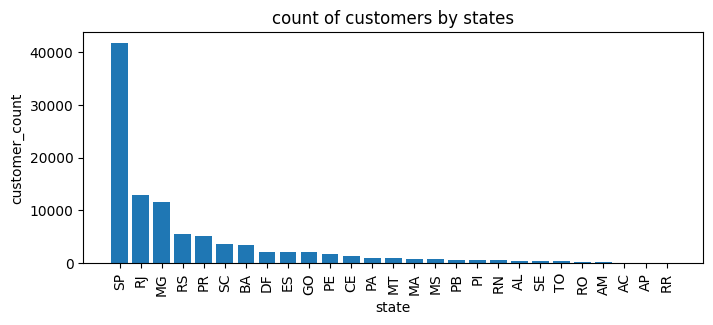

In [45]:
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)
df
plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xlabel("state")
plt.ylabel("customer_count")
plt.title("count of customers by states")
plt.xticks(rotation = 90)
plt.show 

### 1. Calculate the number of orders per month in 2018.

In [57]:
query = """ select month(order_purchase_timestamp) months, count(order_id) order_count
from olist_orders_dataset where year (order_purchase_timestamp) = 2018
group by months 
order by (month(order_purchase_timestamp))"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["Months", "order_count"])
df

,Months,order_count
0,1,7269
1,2,6728
2,3,7211
3,4,6939
4,5,6873
5,6,6167
6,7,6292
7,8,6512
8,9,16
9,10,4


<function matplotlib.pyplot.show(close=None, block=None)>

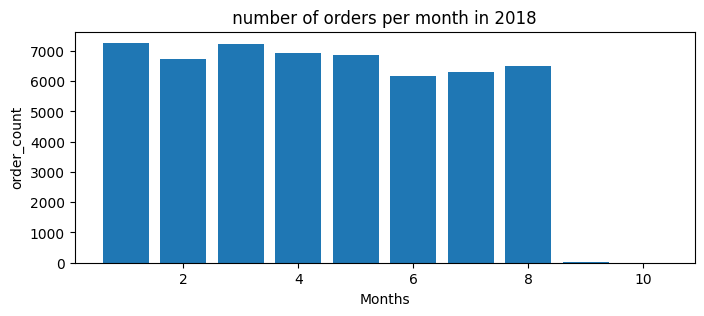

In [68]:
df = pd.DataFrame(data, columns = ["Months", "order_count"])
df = df.sort_values(by = "order_count", ascending = False)
df
plt.figure(figsize = (8,3))
plt.bar(df["Months"], df["order_count"])
plt.xlabel("Months")
plt.ylabel("order_count")
plt.title(" number of orders per month in 2018 ")
plt.xticks(rotation = 0)
plt.show 

### 2.Find the average number of products per order, grouped by customer city.

In [15]:
query = """ with count_per_order as
(select olist_orders_dataset.order_id, olist_orders_dataset.customer_id, count(olist_order_items_dataset.order_id) as oc
from olist_orders_dataset join olist_order_items_dataset
on olist_orders_dataset.order_id = olist_order_items_dataset.order_id
group by olist_orders_dataset.order_id, olist_orders_dataset.customer_id)

select olist_customers_dataset.customer_city, round(avg(count_per_order.oc),2) average_orders
from olist_customers_dataset join count_per_order 
on olist_customers_dataset.customer_id = count_per_order.customer_id
group by olist_customers_dataset.customer_city order by average_orders desc;
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["customer_city", "average_product/order"])
df
df.head(10)

,customer_city,average_product/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


### 3. Calculate the percentage of total revenue contributed by each product category.

In [23]:
query = """ select olist_products_dataset.product_category_name, 
round((sum(olist_order_payments_dataset.payment_value)/ (select sum(payment_value) from olist_order_payments_dataset))*100,2) sales
from olist_products_dataset join olist_order_items_dataset
on olist_products_dataset.product_id = olist_order_items_dataset.product_id
join olist_order_payments_dataset
on olist_order_payments_dataset.order_id = olist_order_items_dataset.order_id
group by product_category_name
order by sales desc;"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["category", "percentage_distribution"])
df



,category,percentage_distribution
0,cama_mesa_banho,10.70
1,beleza_saude,10.35
2,informatica_acessorios,9.90
3,moveis_decoracao,8.93
4,relogios_presentes,8.93
...,...,...
69,casa_conforto_2,0.01
70,cds_dvds_musicais,0.01
71,pc_gamer,0.01
72,fashion_roupa_infanto_juvenil,0.00


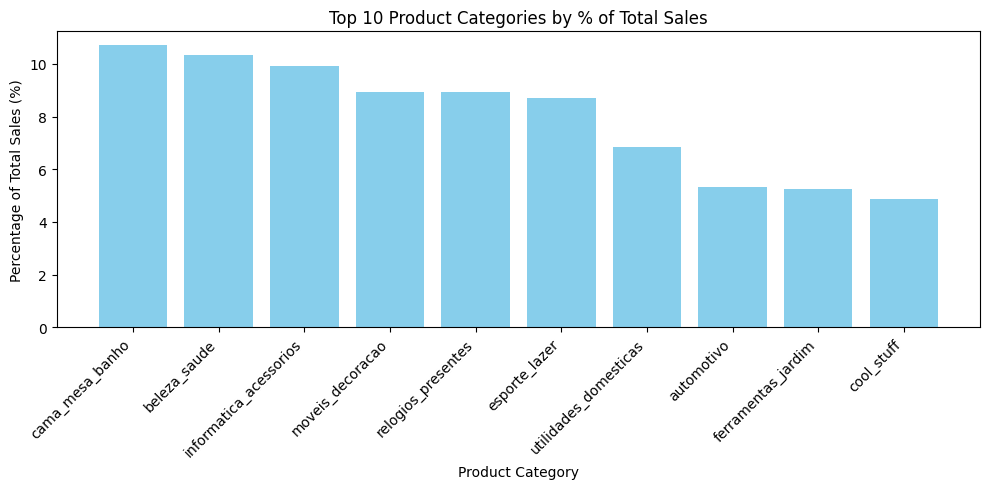

In [19]:
df_top10 = df.head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(df_top10["category"], df_top10["percentage_distribution"], color='skyblue')
plt.xlabel("Product Category")
plt.ylabel("Percentage of Total Sales (%)")
plt.title("Top 10 Product Categories by % of Total Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [27]:
query = """ select olist_products_dataset.product_category_name, 
count(olist_order_items_dataset.product_id), 
round(avg(olist_order_items_dataset.price),2) 
from olist_products_dataset join olist_order_items_dataset 
on olist_products_dataset.product_id = olist_order_items_dataset.product_id 
group by olist_products_dataset.product_category_name ;"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["product_category_name", " order_count", "price"])
df
arr1 = df[" order_count"]
arr2 = df["price"]
a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is", a[0][-1])

the correlation between price and number of times a product has been purchased is -0.10631514167157562


### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

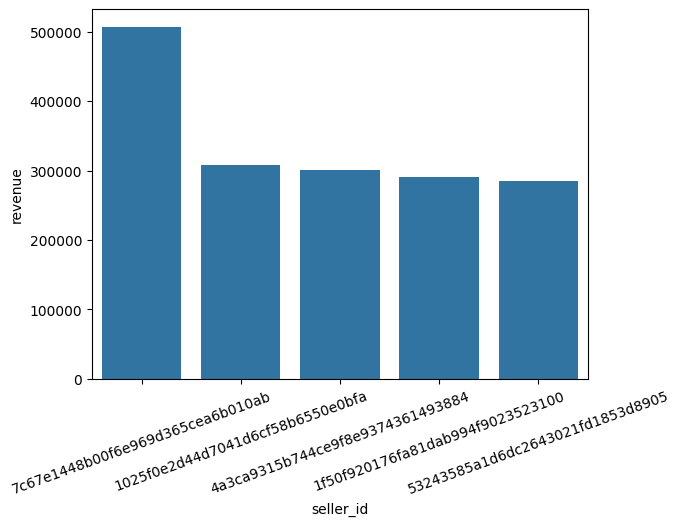

In [29]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from 
(select olist_order_items_dataset.seller_id, sum(olist_order_payments_dataset.payment_value) 
revenue from olist_order_items_dataset join olist_order_payments_dataset 
on olist_order_items_dataset.order_id = olist_order_payments_dataset.order_id 
group by olist_order_items_dataset.seller_id) as a """ 
cur.execute(query) 
data = cur.fetchall() 
df = pd.DataFrame (data, columns = ["seller_id", "revenue", "rank"]) 
df = df.head() 
sns.barplot(x = "seller_id", y = "revenue", data = df) 
plt.xticks(rotation = 20) 
plt.show()

### 1. Calculate the moving average of order values for each customer over their order history.

### 2. Calculate the cumulative sales per month for each year.

### 3. Calculate the year-over-year growth rate of total sales.

### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

### 5. Identify the top 3 customers who spent the most money in each year.

# chatGPT

### 1. What are the unique product categories available?

In [80]:
query = """ select distinct(product_category_name) as products from olist_products_dataset;"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["products"])
df
df.head()

,products
0,perfumaria
1,artes
2,esporte_lazer
3,bebes
4,utilidades_domesticas


### 2. How many sellers are there in the dataset?

In [86]:
query = """ select count(distinct(seller_id)) as total_sellers from olist_sellers_dataset """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["total_sellers"])
df
df.head()

,total_sellers
0,3095


### 3. Find the number of orders per payment type.

In [110]:
query = """ select count(order_id), payment_type from olist_order_payments_dataset
group by payment_type
"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["order_id","payment_type"])
df

,order_id,payment_type
0,76795,credit_card
1,19784,boleto
2,5775,voucher
3,1529,debit_card
4,3,not_defined


<function matplotlib.pyplot.show(close=None, block=None)>

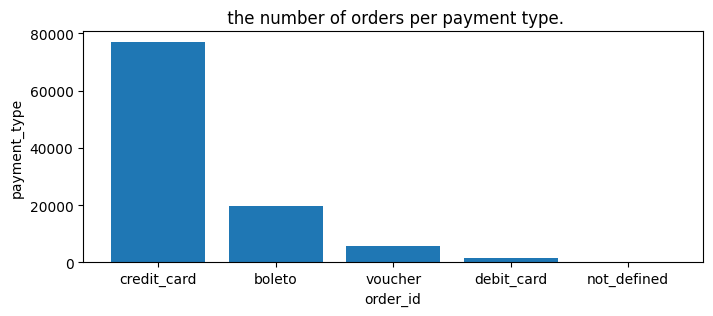

In [111]:
df = pd.DataFrame(data, columns = ["order_id","payment_type"])
df = df.sort_values(by = "order_id", ascending = False)
df
plt.figure(figsize = (8,3))
plt.bar(df["payment_type"], df["order_id"])
plt.xlabel("order_id")
plt.ylabel("payment_type")
plt.title(" the number of orders per payment type.")
plt.xticks(rotation = 0)
plt.show 

### 4. List the top 10 cities with the highest number of orders.

In [112]:
query = """ select olist_customers_dataset.customer_city as city, count(olist_orders_dataset.order_id) as total_orders
from olist_customers_dataset join olist_orders_dataset
on olist_customers_dataset.customer_id = olist_orders_dataset.customer_id
group by city
order by total_orders desc
limit 10;
; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["city","total_orders"])
df

,city,total_orders
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
5,campinas,1444
6,porto alegre,1379
7,salvador,1245
8,guarulhos,1189
9,sao bernardo do campo,938


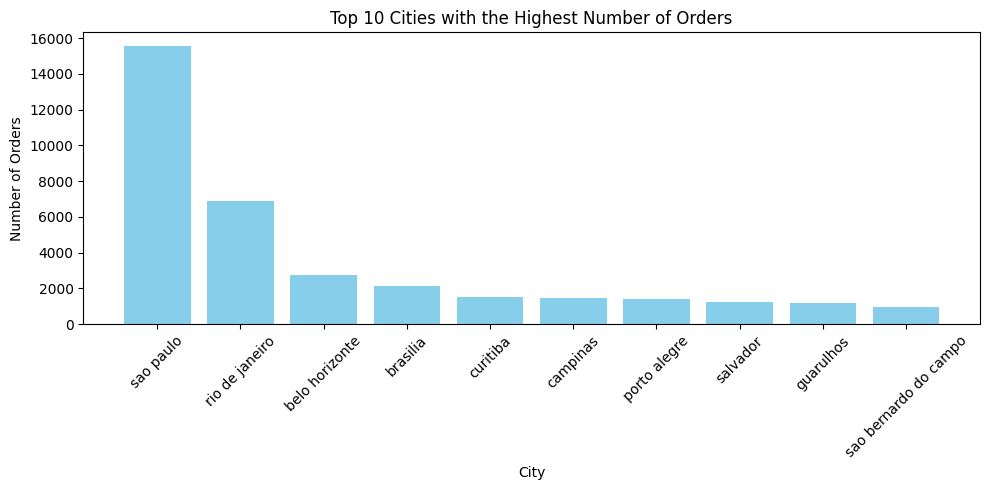

In [113]:
import matplotlib.pyplot as plt

# Sort DataFrame to ensure it's ordered (if not already)
df = df.sort_values(by="total_orders", ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(df["city"], df["total_orders"], color="skyblue")
plt.xlabel("City")
plt.ylabel("Number of Orders")
plt.title("Top 10 Cities with the Highest Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


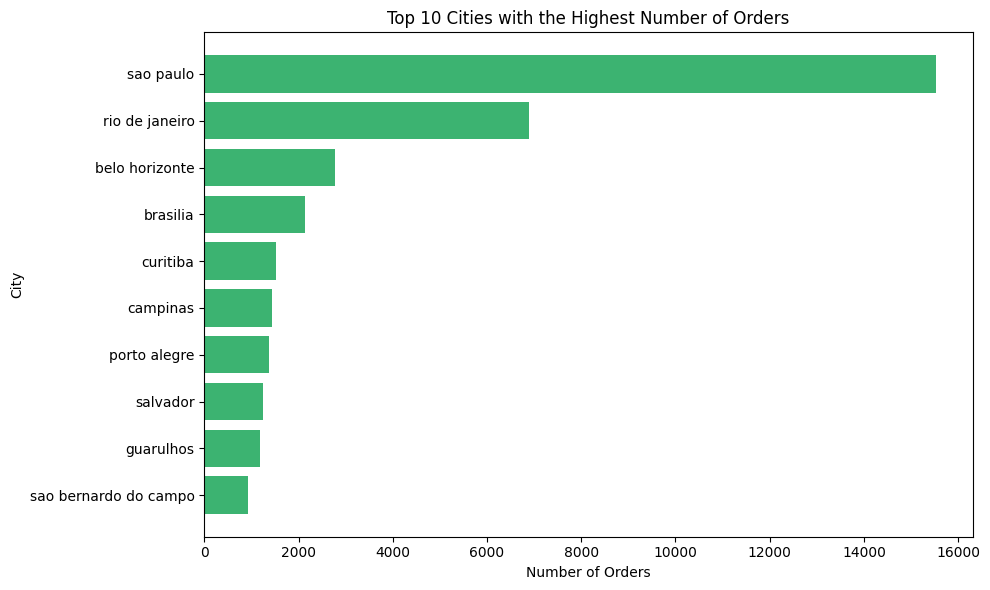

In [114]:
plt.figure(figsize=(10, 6))
plt.barh(df["city"], df["total_orders"], color="mediumseagreen")
plt.xlabel("Number of Orders")
plt.ylabel("City")
plt.title("Top 10 Cities with the Highest Number of Orders")
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()


### 5. Count the number of reviews with each rating (1 to 5).

In [117]:
query = """ select count(review_id), review_score
from olist_order_reviews_dataset
group by review_score;

; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["count of review_id","review_score"])
df

,count of review_id,review_score
0,19142,4
1,57328,5
2,11424,1
3,8179,3
4,3151,2


### 6. Find the earliest and latest order dates in the dataset.

In [115]:
query = """ select order_id, date(order_purchase_timestamp) as earliest
from olist_orders_dataset
order by earliest
limit 1;
; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["order_id","earliest_date_of_order"])
df

,order_id,earliest_date_of_order
0,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04


In [116]:
query = """ select order_id, date(order_purchase_timestamp) as latest
from olist_orders_dataset
order by latest desc
limit 1;
; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["order_id","latest_date_of_order"])
df

,order_id,latest_date_of_order
0,10a045cdf6a5650c21e9cfeb60384c16,2018-10-17


### 1. Calculate average delivery time (from order to delivered date).

### 2. Find the average review score by product category.

In [ ]:
query = """ select olist_products_dataset.product_category_name, avg(olist_order_reviews_dataset.review_score) as avg_prod_review
from olist_products_dataset join olist_order_items_dataset
on olist_products_dataset.product_id = olist_order_items_dataset.product_id
join olist_order_reviews_dataset
on olist_order_reviews_dataset.order_id = olist_order_items_dataset.order_id
group by product_category_name;
 """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["product_category_name","avg_prod_review"])
df

### 3. Analyze average payment value per order status.

In [5]:
query = """ select olist_products_dataset.product_category_name as category, round(avg(olist_order_payments_dataset.payment_value),2) as avg_payment
from olist_products_dataset join olist_order_items_dataset
on olist_products_dataset.product_id = olist_order_items_dataset.product_id
join olist_order_payments_dataset
on olist_order_payments_dataset.order_id = olist_order_items_dataset.order_id
group by product_category_name
"""
cur.execute(query)
data = cur.fetchall()
data
# and if i want to dataframe
df = pd.DataFrame(data, columns = ["Catogory", "avg_payment"])
df

,Catogory,avg_payment
0,perfumaria,142.34
1,moveis_decoracao,163.56
2,telefonia,103.13
3,fashion_bolsas_e_acessorios,101.42
4,cama_mesa_banho,144.85
...,...,...
69,cds_dvds_musicais,85.67
70,la_cuisine,182.10
71,fashion_roupa_infanto_juvenil,98.21
72,pc_gamer,217.44


### 5. Identify the number of sellers with sales above a certain threshold.

In [ ]:
###  1. Predict average delivery time per region using historical data.

In [9]:
###  2. Cluster customers based on total spending and number of orders.

In [8]:
###  3. Analyze refund or cancellation patterns (if status column allows).

In [ ]:
###  4. Identify peak sales hours (if timestamp available).